# Web scraping: Tipico live sports betting 

This notebook uses the BeautifulSoup library to scrape information about live soccer games from tipico.de.
It stores all information in pd dataframes and exports them into csv-files for further analyses.

## Import relevant libraries

In [1]:
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from bs4 import BeautifulSoup
import urllib.request
import re

## Load and parse Tipico website source code

In [165]:
url = "https://www.tipico.de/de/live-wetten/"

try:
    page = urllib.request.urlopen(url)
except:
    print("An error occured.")

soup = BeautifulSoup(page, 'html.parser')
#print(soup)

## Extract relevant information from source code

In [166]:
regex = re.compile('c_but_base c_but')
content_lis = soup.find_all('button', attrs={'class': regex})
#print(content_lis)

In [167]:
content = []
for li in content_lis:
    content.append(li.getText().replace("\n","").replace("\t",""))
#print(content)

In [168]:
regex_names = re.compile('team')
content_lis_names = soup.find_all('div', attrs={'class': regex_names})
#print(content_lis_names)

In [169]:
content_names = []
for li in content_lis_names:
    content_names.append(li.getText().split('\n\t')[0])
#print(content_names)

In [170]:
regex_minute = re.compile('c_1 time pulsation')
content_lis_minute = soup.find_all('div', attrs={'class': regex_minute})
#print(content_lis_minute)

In [171]:
content_minute = []
for li in content_lis_minute:
    if (li.getText().replace("\n","").replace("\t","").replace("\xa0","").replace("'","") != ""):
        content_minute.append(li.getText().replace("\n","").replace("\t","").replace("\xa0","").replace("'",""))
#print(content_minute)

In [172]:
regex_score = re.compile('score')
content_lis_score = soup.find_all('div', attrs={'class': regex_score})
#print(content_lis_score)

In [173]:
content_score = []
for li in content_lis_score:
    content_score.append(li.getText().replace("\n","").replace("\t","").replace("\xa0",""))
#print(content_score)

## Store information in dataframe

In [197]:
# Need to find the number of active soccer games to scrape all of them
# as their positions change frequently. Also, if we try to scrape more
# games than there are available in general, the script will interrupt.

# Find the first tennis game by looking for Set
matching = [s for s in content_minute if "Set" in s]

# Get minimum index
minlist = []
for s in np.unique(matching):
    minlist.append(content_minute.index(s))

minidx = np.min(minlist)

In [175]:
# We also need to add all "1. Halbzeit" to get the correct index of 
# number of soccer games.

cnt_halbzeit = [s for s in content_names if s == '1. Halbzeit']
shift = len(cnt_halbzeit)

In [176]:
N_games = minidx+shift # number of games observed, retrieved from above
N_players = 2 # number of players per game
N_outcomes = 11 # number of possible outcomes (Win, lose, tie, Next goal etc.)
df = []
k = 0 # Shift player names to correct the "1. Halbzeit" entries
j = 0 # Shift minutes to correct the "1. Halbzeit" entries
for i in range(N_games):
    # When there is a "1. Halbzeit", there is only on entry for the player names and it must be shifted
    if content_names[0+i*N_players+k] == "1. Halbzeit":
        j = j-1 # correct minute
        df.append([datetime.now(), content_names[i*N_players+k], "", content_minute[j],
        content_score[j], content[i*N_outcomes], content[1+i*N_outcomes], content[2+i*N_outcomes], 
        content[6+i*N_outcomes], content[7+i*N_outcomes], content[8+i*N_outcomes]])
        k = k-1 # correct player name for halftime

    else:
        df.append([datetime.now(), content_names[i*N_players+k], content_names[1+i*N_players+k], content_minute[j],
        content_score[j], content[i*N_outcomes], content[1+i*N_outcomes], content[2+i*N_outcomes],
        content[6+i*N_outcomes], content[7+i*N_outcomes], content[8+i*N_outcomes]])

    j += 1
#df

In [195]:
pdf = pd.DataFrame(df, columns = ['Time', 'Player_1', 'Player_2', 'MinuteOfGame', 'Score', 'Win_1', 'Win_X', 'Win_2', 
                                  'NextGoal_1' , 'NextGoal_X' , 'NextGoal_2' ])
#pdf['Score'] = pdf['Score'].astype(str)
pdf.head()

,Time,Player_1,Player_2,MinuteOfGame,Score,Win_1,Win_X,Win_2,NextGoal_1,NextGoal_X,NextGoal_2
0,2019-09-22 17:31:44.492092,FC Arsenal,Aston Villa,1,0:0,"1,4","4,7","7,5","1,4",20,"3,0"
1,2019-09-22 17:31:44.492092,1. Halbzeit,,1,0:0,"1,9","2,55","5,5","1,75","3,8","3,8"
2,2019-09-22 17:31:44.492092,FC Chelsea,FC Liverpool,2,0:0,"3,2","3,8","2,1","2,1",15,"1,75"
3,2019-09-22 17:31:44.492092,1. Halbzeit,,2,0:0,"3,4","2,3","2,6","2,7","3,6","2,2"
4,2019-09-22 17:31:44.492092,Valencia C.F.,CD Leganes,69,1:1,"2,7","1,75","7,0","2,5","1,9","5,5"


# Write results into functions

In [3]:
def get_soccer_rates_tipico():
    """
    This function creates a table with the live betting information,
    this includes a timestamp, the players, the score and the rates
    for each party winning and scoring the next goal.
    
    Arguments:
    None
    
    Returns:
    pdf -- pandas dataframe with the results of shape (N_games, 11)
    """
    
    ## SCRAPE AND PARSE TIPICO
    
    # Retrieve source code from tipico live betting page and create soup
    url = "https://www.tipico.de/de/live-wetten/"

    try:
        page = urllib.request.urlopen(url)
    except:
        print("An error occured.")

    soup = BeautifulSoup(page, 'html.parser')

    # Read out betting rates
    regex = re.compile('c_but_base c_but')
    content_lis = soup.find_all('button', attrs={'class': regex})
    content = []
    for li in content_lis:
        content.append(li.getText().replace("\n","").replace("\t",""))

    # Read out names of players
    regex_names = re.compile('team')
    content_lis_names = soup.find_all('div', attrs={'class': regex_names})
    content_names = []
    for li in content_lis_names:
        content_names.append(li.getText().split('\n\t')[0])

    # Read out minutes of each game
    regex_minute = re.compile('c_1 time pulsation')
    content_lis_minute = soup.find_all('div', attrs={'class': regex_minute})
    content_minute = []
    for li in content_lis_minute:
        # Sometimes it finds blanks, they must be skipped to keep the order
        if (li.getText().replace("\n","").replace("\t","").replace("\xa0","").replace("'","") != ""):
            content_minute.append(li.getText().replace("\n","").replace("\t","").replace("\xa0","").replace("'",""))

    # Read out scores of each game
    regex_score = re.compile('score')
    content_lis_score = soup.find_all('div', attrs={'class': regex_score})
    content_score = []
    for li in content_lis_score:
        content_score.append(li.getText().replace("\n","").replace("\t","").replace("\xa0",""))
    
    ## STORE AND RETURN RESULTS IN DATAFRAME
    
    # Define number players and outcomes to correctly transfer data into table
    
    # Need to find the number of active soccer games to scrape all of them
    # as their positions change frequently. Also, if we try to scrape more
    # games than there are available in general, the script will interrupt.

    # Find the first tennis game by looking for Set
    matching = [s for s in content_minute if "Set" in s]

    # Get minimum index
    minlist = []
    for s in np.unique(matching):
        minlist.append(content_minute.index(s))

    minidx = np.min(minlist)
    # We also need to add all "1. Halbzeit" to get the correct index of 
    # number of soccer games.

    cnt_halbzeit = [s for s in content_names if s == '1. Halbzeit']
    shift = len(cnt_halbzeit)
    
    N_games = minidx+shift # number of games observed, retrieved from above
    N_players = 2 # number of players per game
    N_outcomes = 11 # number of possible outcomes (Win, lose, tie, Next goal etc.)
    
    df = []
    k = 0 # Shift player names to correct the "1. Halbzeit" entries
    j = 0 # Shift minutes to correct the "1. Halbzeit" entries
    for i in range(N_games):
        # When there is a "1. Halbzeit", there is only on entry for the player names and it must be shifted
        if content_names[0+i*N_players+k] == "1. Halbzeit":
            j = j-1 # correct minute
            df.append([datetime.now(), content_names[i*N_players+k], "", content_minute[j],
            content_score[j], content[i*N_outcomes], content[1+i*N_outcomes], content[2+i*N_outcomes], 
            content[6+i*N_outcomes], content[7+i*N_outcomes], content[8+i*N_outcomes]])
            k = k-1 # correct player name for halftime

        else:
            df.append([datetime.now(), content_names[i*N_players+k], content_names[1+i*N_players+k], content_minute[j],
            content_score[j], content[i*N_outcomes], content[1+i*N_outcomes], content[2+i*N_outcomes],
            content[6+i*N_outcomes], content[7+i*N_outcomes], content[8+i*N_outcomes]])

        j += 1
        
    # Load results into pandas dataframe
    pdf = pd.DataFrame(df, columns = ['Time', 'Player_1', 'Player_2', 'MinuteOfGame', 'Score', 'Win_1', 'Win_X', 'Win_2', 
                                  'NextGoal_1' , 'NextGoal_X' , 'NextGoal_2' ])    

    return pdf

In [194]:
#get_soccer_rates_tipico()

In [5]:
def repeat_scraping(timedelay, number_of_scrapes, filename = 'bet_rates_scraping_tipico.csv'):
    """
    This function repeadetly calls the scraping function to create a timeseries
    of scraping data. The time interval between scrapes and number of scrapes
    in total are taken as argument. The result is saved in a csv-file.
    
    Arguments:
    timedelay -- delay between each scrape request in seconds (min. 15 sec recommended due to processing time)
    number_of_scrapes --  number of scrape requests 
    
    Returns:
    Void
    """
    
    ## CALL AND REPEAT SCRAPING FUNCTION
    runs = 0
    while runs < number_of_scrapes:
        
        start_time = time.time()
        runs += 1
        
        # Print progress every 10 runs
        if ( (np.mod(runs,10) == 0) or (runs == 1) ):
            print("Scraping run number: " + str(runs) + " / " + str(number_of_scrapes) + " (timedelay is " + str(timedelay) +")")
        
        pdf = get_soccer_rates_tipico()
        
        # Check if a .csv file exists, if yes append new information, else create a new file
        try:
            dataframe = pd.read_csv(filename, encoding = 'unicode_escape')
            dataframe = pd.concat([dataframe, pdf], ignore_index=True)
            dataframe.to_csv(filename, index=False)
        except:
            print("Couldn't find ", filename)
            print("Created as new file: ", filename)
            dataframe = pdf.to_csv(filename, index=False)
        
        # Check processing time and add sleeping time to fit the timedelay
        time_run = time.time() - start_time
        time.sleep(timedelay - time_run)

# Scrape games

In [ ]:
# Input: timedelay, number_of_scrapes, N_games, filename 
repeat_scraping(15, 500, 'scraping_500x15s.csv') # Every 15 seconds for an entire game ~115 minutes and 6 scrapes/min = 460 scrapes

# Analyse games

In [52]:
dataframe = pd.read_csv('scraping_500x15s.csv', encoding = 'unicode_escape')

In [53]:
dataframe.head()

,Time,Player_1,Player_2,MinuteOfGame,Score,Win_1,Win_X,Win_2,NextGoal_1,NextGoal_X,NextGoal_2
0,2019-09-21 15:34:36.136,Bayern München,1.FC Köln,5,1:0,"1,02",20,50,"1,16",30,"4,7"
1,2019-09-21 15:34:36.136,1. Halbzeit,NaN,5,1:0,"1,04",10,30,"1,4","4,5","6,0"
2,2019-09-21 15:34:36.136,Bayer Leverkusen,FC Union Berlin,5,0:0,"1,35","5,2","8,5","1,3",20,"3,4"
3,2019-09-21 15:34:36.136,1. Halbzeit,NaN,5,0:0,"1,75","2,6","6,5","1,65","4,0","4,0"
4,2019-09-21 15:34:36.136,Hertha BSC,SC Paderborn,3,0:0,"1,55","4,5","5,2","1,45",20,"2,7"


## Clean data, replace NaNs, convert commas to dots and strings to floats

In [55]:
dataframe = dataframe.fillna(0)

In [56]:
ratecols = ['Win_1','Win_X','Win_2','NextGoal_1','NextGoal_X','NextGoal_2']

In [57]:
dataframe[ratecols] = dataframe[ratecols].apply(lambda x: x.str.replace(',','.')).astype(float)

In [59]:
dataframe['Time_parsed'] = 0

In [60]:
# Check for dates without milliseconds and add .000 to have a consistent formatting
dataframe.Time.iloc[np.where(dataframe.Time.apply(lambda x: True if len(x) == 19 else False))] \
= dataframe.Time.iloc[np.where(dataframe.Time.apply(lambda x: True if len(x) == 19 else False))].apply(lambda t: t + ".000")

C:\Users\5406\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
dataframe.Time_parsed = dataframe.Time.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').time())

In [62]:
dataframe = dataframe.drop(['Time'], axis=1)

In [63]:
#dataframe = dataframe.drop(dataframe.index[np.where(dataframe['Player_1'] == '1. Halbzeit')[0]])
#dataframe.reset_index(drop = True)

## Extract one single game

In [101]:
df1 = dataframe[dataframe['Player_1'] == dataframe['Player_1'][0]]
df1

,Player_1,Player_2,MinuteOfGame,Score,Win_1,Win_X,Win_2,NextGoal_1,NextGoal_X,NextGoal_2,Time_parsed
0,Bayern München,1.FC Köln,5,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:34:36.136000
111,Bayern München,1.FC Köln,5,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:34:50.404000
222,Bayern München,1.FC Köln,5,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:35:08.825000
333,Bayern München,1.FC Köln,6,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:35:21.867000
445,Bayern München,1.FC Köln,6,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:35:39.425000
557,Bayern München,1.FC Köln,6,1:0,1.02,20.0,50.0,1.16,30.00,4.7,15:35:50.874000
669,Bayern München,1.FC Köln,6,1:0,1.02,20.0,50.0,1.18,30.00,4.5,15:36:06.410000
781,Bayern München,1.FC Köln,7,1:0,1.02,20.0,50.0,1.18,30.00,4.5,15:36:22.547000
893,Bayern München,1.FC Köln,7,1:0,1.04,15.0,50.0,1.20,30.00,4.3,15:36:37.252000
1005,Bayern München,1.FC Köln,7,1:0,1.04,15.0,50.0,1.20,30.00,4.3,15:36:51.634000


## Plot results

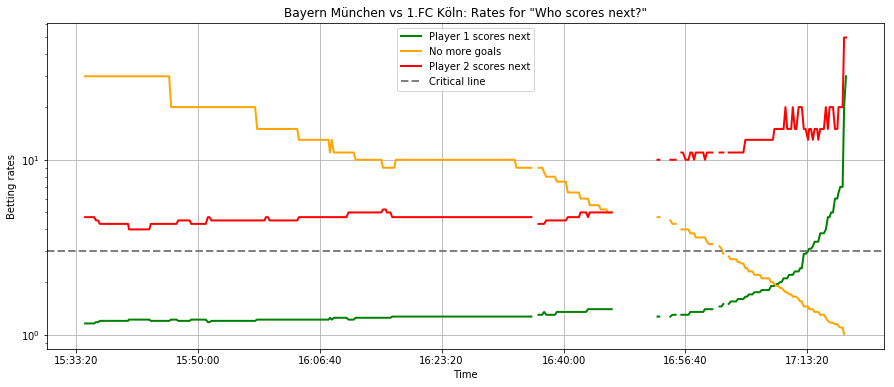

In [187]:
# Data for plotting
t = df1.Time_parsed.values
w1 = df1.NextGoal_1.values
w2 = df1.NextGoal_X.values
w3 = df1.NextGoal_2.values

# Plot setup
fig, ax = plt.subplots(figsize=(15, 6))        
ax.plot(t, w1, marker ='', label = 'Player 1 scores next' ,color = 'green', linewidth = 2)
ax.plot(t, w2, marker ='', label = 'No more goals', color = 'orange', linewidth = 2)
ax.plot(t, w3, marker ='', label = 'Player 2 scores next', color = 'red', linewidth = 2)
plt.axhline(y=3., label = 'Critical line', color='grey', linewidth = 2, linestyle='--') # Line for arbitrage detection 

ax.set(xlabel='Time', ylabel='Betting rates', title=str(np.unique(df1.Player_1)[0]) + ' vs ' + \
               str(np.unique(df1.Player_2)[0]) + ': Rates for "Who scores next?"')
ax.grid()
plt.legend()

ax.set_yscale('log')

In [103]:
def generate_plots(df = df1, ratetype = 'win', outname = 'plot1.jpg', noshow = False):
    # Data for plotting
    t = df1.Time_parsed.values
    s1 = df1.Win_1.values
    s2 = df1.Win_X.values
    s3 = df1.Win_2.values
    w1 = df1.NextGoal_1.values
    w2 = df1.NextGoal_X.values
    w3 = df1.NextGoal_2.values

    # Plot setup
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Select which rates to show
    if ratetype == 'win':
        ax.plot(t, s1, marker ='', label = 'Player 1 wins' ,color = 'green', linewidth = 2)
        ax.plot(t, s2, marker ='', label = 'Tie', color = 'orange', linewidth = 2)
        ax.plot(t, s3, marker ='', label = 'Player 1 loses', color = 'red', linewidth = 2)
        ax.set(xlabel='Time', ylabel='Betting rates', title=str(np.unique(df1.Player_1)[0]) + ' vs ' + \
               str(np.unique(df1.Player_2)[0]) + ': Rates for "Who wins the game?"')
    elif ratetype == 'next_goal':
        ax.plot(t, w1, marker ='', label = 'Player 1 scores next' ,color = 'green', linewidth = 2)
        ax.plot(t, w2, marker ='', label = 'No more goals', color = 'orange', linewidth = 2)
        ax.plot(t, w3, marker ='', label = 'Player 2 scores next', color = 'red', linewidth = 2)
        ax.set(xlabel='Time', ylabel='Betting rates', title=str(np.unique(df1.Player_1)[0]) + ' vs ' + \
               str(np.unique(df1.Player_2)[0]) + ': Rates for "Who scores next?"')

        
    plt.axhline(y=3., label = 'Critical line', color='grey', linewidth = 2, linestyle='--') # Line for arbitrage detection 

    ax.grid()
    plt.legend()

    ax.set_yscale('log')

    fig.savefig('plots/' + str(outname))
    if noshow == True:
        plt.close('all')

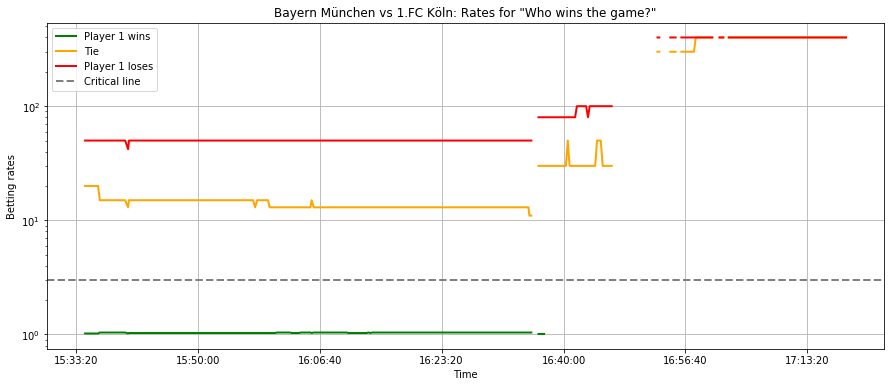

In [104]:
generate_plots()

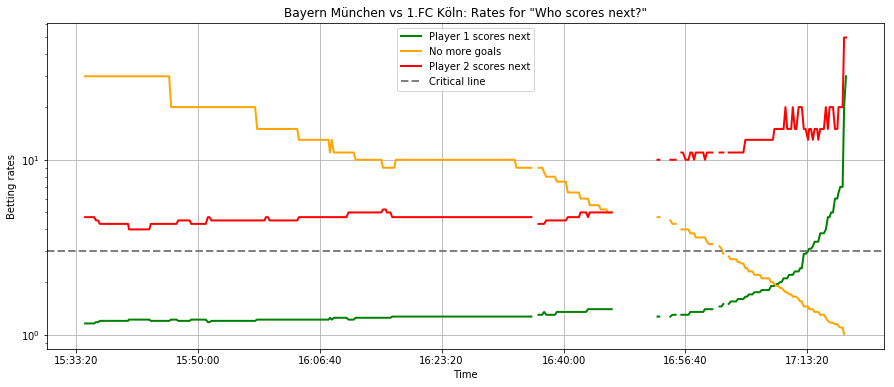

In [105]:
generate_plots(ratetype='next_goal')

In [82]:
# Generate all plots

# Wins
for i in range(len(np.unique(dataframe.Player_1))):
    df1 = dataframe[dataframe['Player_1'] == dataframe['Player_1'][i]]
    if dataframe['Player_1'][i] != '1. Halbzeit':
        generate_plots(outname = 'plot_win_' + str(i) + '.jpg', noshow=True)

# Next goals
for i in range(len(np.unique(dataframe.Player_1))):
    df1 = dataframe[dataframe['Player_1'] == dataframe['Player_1'][i]]
    if dataframe['Player_1'][i] != '1. Halbzeit':
        generate_plots(ratetype = 'next_goal', outname = 'plot_goal_' + str(i) + '.jpg', noshow=True)   

## Tag potential arbitrage bets and calculate profits

In [147]:
# There still seems to be an error while scraping (also visible by the outliers in the plots)
# therefore the tagges events are probably no arbitrage chances but errors

In [148]:
df2 = dataframe.copy()

In [192]:
df2['Check_a_1'] = df2.Win_1.apply(lambda x: 1/x)
df2['Check_a_2'] = df2.Win_X.apply(lambda x: 1/x)
df2['Check_a_3'] = df2.Win_2.apply(lambda x: 1/x)
df2['Check_a_sum']=0
df2['Check_b_1'] = df2.NextGoal_1.apply(lambda x: 1/x)
df2['Check_b_2'] = df2.NextGoal_X.apply(lambda x: 1/x)
df2['Check_b_3'] = df2.NextGoal_2.apply(lambda x: 1/x)
df2['Check_b_sum']=0
df2['Arbitrage_flag']=0
#df2.head()

In [193]:
df2['Check_a_sum'] = df2.Check_a_1 + df2.Check_a_2 + df2.Check_a_3
df2['Check_b_sum'] = df2.Check_b_1 + df2.Check_b_2 + df2.Check_b_3
#df2.head()

In [190]:
# Find all indices, where each rate of a 3-outcome-event was 3 or higher
arb_idx = np.unique(np.append(np.where(df2.Check_a_sum <= 1)[0],np.where(df2.Check_b_sum <= 1)[0]))

In [152]:
df2.Arbitrage_flag[arb_idx] = 1

C:\Users\5406\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
# Show results
arb_df = df2.iloc[arb_idx]
arb_df.head()

,Player_1,Player_2,MinuteOfGame,Score,Win_1,Win_X,Win_2,NextGoal_1,NextGoal_X,NextGoal_2,Time_parsed,Check_a_1,Check_a_2,Check_a_3,Check_a_sum,Check_b_1,Check_b_2,Check_b_3,Check_b_sum,Arbitrage_flag
16,Chemnitzer FC,Carl Zeiss Jena,76,1:2,1.8,15.0,4.0,4.0,3.00,2.10,15:34:36.137000,0.555556,0.066667,0.250000,0.872222,0.250000,0.333333,0.476190,1.059524,1
17,Altay Izmir,Keciörengücü,4,0:0,2.1,1.8,3.4,4.0,1.60,10.00,15:34:36.137000,0.476190,0.555556,0.294118,1.325864,0.250000,0.625000,0.100000,0.975000,1
19,Osmanlispor FK,Altinordu,4,0:0,2.7,2.1,3.4,3.2,1.75,10.00,15:34:36.137000,0.370370,0.476190,0.294118,1.140678,0.312500,0.571429,0.100000,0.983929,1
21,FC Gießen,1. FC Saarbrücken,77,0:2,2.8,80.0,30.0,3.0,4.50,1.80,15:34:36.137000,0.357143,0.012500,0.033333,0.402976,0.333333,0.222222,0.555556,1.111111,1
22,VFR Aalen,TSG Balingen,74,1:2,1.8,12.0,3.5,6.0,2.60,1.85,15:34:36.137000,0.555556,0.083333,0.285714,0.924603,0.166667,0.384615,0.540541,1.091823,1


In [154]:
arb_df.to_excel('Arbitragelist.xlsx')

## Calculate distribution of betting amounts to make the profit independent of game results

In [155]:
# Give the first bet the weight of 1 and adjust the other two bets accordingly
df2['Win_1_betting_fraction'] = 1
df2['NextGoal_1_betting_fraction'] = 1

In [156]:
# If rate * amount = profit and we want to make the profit independent of the outcome, we know that 
# amount_j = rate_1 / rate_j * amount_1
df2['Win_X_betting_fraction'] = df2.Win_1 / df2.Win_X
df2['Win_2_betting_fraction'] = df2.Win_1 / df2.Win_2
df2['NextGoal_X_betting_fraction'] = df2.NextGoal_1 / df2.NextGoal_X
df2['NextGoal_2_betting_fraction'] = df2.NextGoal_1 / df2.NextGoal_2

In [157]:
# Distribute betting amounts
df2['Win_1_betting_amount'] = 1 / ( df2.Win_1_betting_fraction + df2.Win_X_betting_fraction + df2.Win_2_betting_fraction )
df2['Win_X_betting_amount'] = df2.Win_X_betting_fraction / ( df2.Win_1_betting_fraction + df2.Win_X_betting_fraction + \
                                                             df2.Win_2_betting_fraction )
df2['Win_2_betting_amount'] = df2.Win_2_betting_fraction / ( df2.Win_1_betting_fraction + df2.Win_X_betting_fraction + \
                                                             df2.Win_2_betting_fraction )
df2['NextGoal_1_betting_amount'] = 1 / ( df2.NextGoal_1_betting_fraction + df2.NextGoal_X_betting_fraction + \
                                         df2.NextGoal_2_betting_fraction)
df2['NextGoal_X_betting_amount'] = df2.NextGoal_X_betting_fraction / ( df2.NextGoal_1_betting_fraction + \
                                         df2.NextGoal_X_betting_fraction + df2.NextGoal_2_betting_fraction)
df2['NextGoal_2_betting_amount'] = df2.NextGoal_2_betting_fraction / ( df2.NextGoal_1_betting_fraction + \
                                         df2.NextGoal_X_betting_fraction + df2.NextGoal_2_betting_fraction)

In [191]:
df2['Win_profit_percentage'] = df2.Win_1 * df2.Win_1_betting_amount * 100 - 100
df2['NextGoal_profit_percentage'] = df2.NextGoal_1 * df2.NextGoal_1_betting_amount * 100 - 100
#df2.loc[np.unique(np.append(np.where(df2.Win_profit_percentage > 0)[0], np.where(df2.NextGoal_profit_percentage > 0)[0]))]